Latent Dirichlet Allocation (LDA) is a popular form of statistical topic modeling. In LDA, documents are represented as a mixture of topics and a topic is a bunch of words. Those topics reside within a hidden, also known as a latent layer. 

LDA looks at a document to determine a set of topics that are likely to have generated that collection of words. So, if a document uses certain words that are contained in a topic, you could say the document is about that topic.

https://blog.marketmuse.com/glossary/latent-dirichlet-allocation-definition/

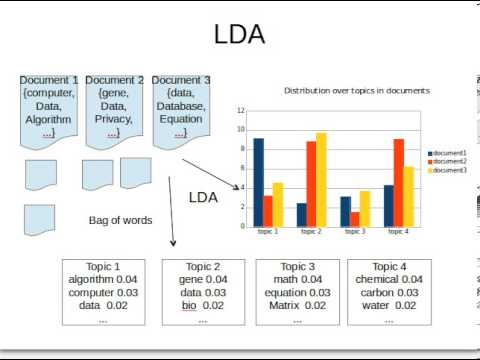

### Load dependencies and helper functions

In [634]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import math


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(math.ceil(len(model.components_)/5), 5, figsize=(20, 6*math.ceil(len(model.components_)/5)), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()
    

def get_topic_names(model, feature_names, n_top_words):
    topic_names = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        top_features = [str(topic_idx+1)]+top_features
        topic_names.append("_".join(top_features))
        
        
    return topic_names

    

### We created a clean data set of articles, titles and most recent publish dates for this exercise - you can find the dataset here - 

In [635]:
data = pd.read_csv("./data/wp_posts_cleaned.csv")

In [636]:
data.head()

,title,content,link,date,author,type
0,9 eventos de Halloween que no te puedes perder...,Por si andas buscando a qué fiesta llegar ante...,https://www.plateapr.com/eventos-de-halloween-...,2022-10-14T07:05:00,13,post
1,8 terrazas únicas donde puedes tomarte un buen...,En Puerto Rico no faltan los coffee shops. Ya ...,https://www.plateapr.com/terrazas-unicas-donde...,2022-10-13T13:18:57,13,post
2,Todo lo que puedes hacer en Caguas con solo $30,En el amplio valle de Caguas puedes toparte co...,https://www.plateapr.com/que-hacer-en-caguas-p...,2022-10-11T14:20:40,13,post
3,"Jazz, laberintos embrujados y otras 8 activida...","Llegó el mes de las brujas y con él, todas las...",https://www.plateapr.com/que-hacer-este-fin-de...,2022-10-07T02:24:00,13,post
4,3 restaurantes que dan cátedra de recuperación...,A la hora de ser solidarios en la recuperación...,https://www.plateapr.com/restaurantes-recupera...,2022-10-05T17:27:05,34,post


In [637]:
data.shape

(184, 6)

In [638]:
texts = data.content

### Vectorizing Text

First, we're going to turn our original unstructured data (raw text) into a form usable by ML models.

The technique we are going to use to turn our text data into a numeric matrix is called "bag of words" - 
- 1 document = 1 row
- 1 word in our vocabulary = 1 column
- each entry = count of occurences of that word (column) in that document (row)

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer

In [639]:
places_tags = ['restaurantes',
 'ocean-park',
 'aire-libre',
 'fine-dining',
 'deportes',
 'hospedajes',
 'boutique-hotels',
 'comida-italiana',
 'cocteles',
 'hiking',
 'cuevas',
 'clases-y-workshops',
 'bakery',
 'wi-fi',
 'aventura',
 'drinks',
 'entretenimiento',
 'panaderias',
 'coffee-shops',
 'bed-amp-breakfast',
 'dinner',
 'tapas',
 'arte-y-cultura',
 'hidden-gem',
 'seafood',
 'comida-del-medio-oriente',
 'ecoturismo',
 'adventure',
 'turismo-interno',
 'mariscos',
 'familiar',
 'comida-internacional',
 'comida-americana',
 'opciones-vegetarianas-y-veganas',
 'airbnb',
 'budget-friendly',
 'food-truck',
 'reposteria',
 'brewery',
 'musica-en-vivo',
 'tours',
 'area-metro',
 'playas',
 'barras',
 'nightlife',
 'eventos',
 'parques-y-reservas',
 'shopping',
 'outdoor-dining',
 'speakeasy',
 'plaza-publica',
 'comida-vegetariana-y-vegana',
 'things-to-do',
 'comida-criolla',
 'juegos-y-diversion',
 'parking',
 'chinchorro',
 'casual-dining',
 'comida-fusion',
 'family-friendly',
 'parques',
 'museos',
 'comida-mexicana',
 'gratis',
 'pizzeria',
 'heladerias',
 'comida-asiatica',
 'mountain-bike',
 'pet-friendly',
 'rooftop',
 'postres',
 'adjuntas',
 'brunch']

places_tags = [s.split('-') for s in places_tags]



tags = []
for t in places_tags:
    if isinstance(t, list):
        tags = tags + t
    else:
        tags.append(t)
        
        
tags = ['parking']

In [640]:
# Stop Words in spanish from: https://github.com/Alir3z4/stop-words/blob/master/spanish.txt
# In addition to those we added the stop words for english since we do have some spanglish on the blogs

stop_words = []

with open("./data/stop_words.txt", "r") as file:
    stop_words = file.readlines()
stop_words = [s.strip().lower() for s in stop_words]
stop_words = stop_words + tags
stop_words[len(stop_words)-10: len(stop_words)-1]

['san juan', 'to', 'that', 'we', 'this', 'on', 'other', 'under', '']

In [641]:
#define our vectorizer class


# We also tried the Tfid vectorizer but the results on the CountVectorizer seemed better.
# tf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words=stop_words, ngram_range=(1,2))


In [642]:
#fit the vectorizer to our text data and apply the transformation
tf = tf_vectorizer.fit_transform(texts)

In [643]:
# Each document is now a 1x10000 matrix as described above, and we have 10000 documents
print("Shape =",tf.shape)

Shape = (184, 10000)


In [644]:
#'tf_vectorizer.vocabulary_' this is our "vocabulary" that we inferred from the text 
#each word token we extracted and the count of that word token across the corpus
pd.DataFrame.from_dict(tf_vectorizer.vocabulary_,orient = "index").head(30)

,0
andas,1228
buscando,2100
fiesta,4433
llegar,5683
acabe,845
semana,8495
brujas,2038
lista,5640
decidir,3258
favorita,4395


### Set up the LDA Model

Similar to many clustering techniques, one of the main inputs to LDA is the number of topics - `n_components`.

There are other related techniques that try to infer the number of topics from the data itself such as hierarchical LDA - but the "base" model requires that input.

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [645]:
n_components = 5
n_top_words = 20

lda = LatentDirichletAllocation(
    n_components=n_components,
    max_iter=5,
    random_state=0,
    verbose = 2 # this could take a little bit, so we specify higher verbosity for some logs
)

##### Fit our LDA model and store the topic distributions for each document in `clusters`

In [646]:
clusters = lda.fit_transform(tf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


iteration: 1 of max_iter: 5
iteration: 2 of max_iter: 5


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


iteration: 3 of max_iter: 5
iteration: 4 of max_iter: 5
iteration: 5 of max_iter: 5


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


### Now, we can visualize our topics

You can try playing around with different params and see what results you get.

The main things to tune are:
1. The number of topics - `n_components`
2. The parameters of the CountVectorizer - which basically play with how many words you would extract from the text and some logic on top of that, and therefore how many/what type of columns you have in your vectorized matrix.

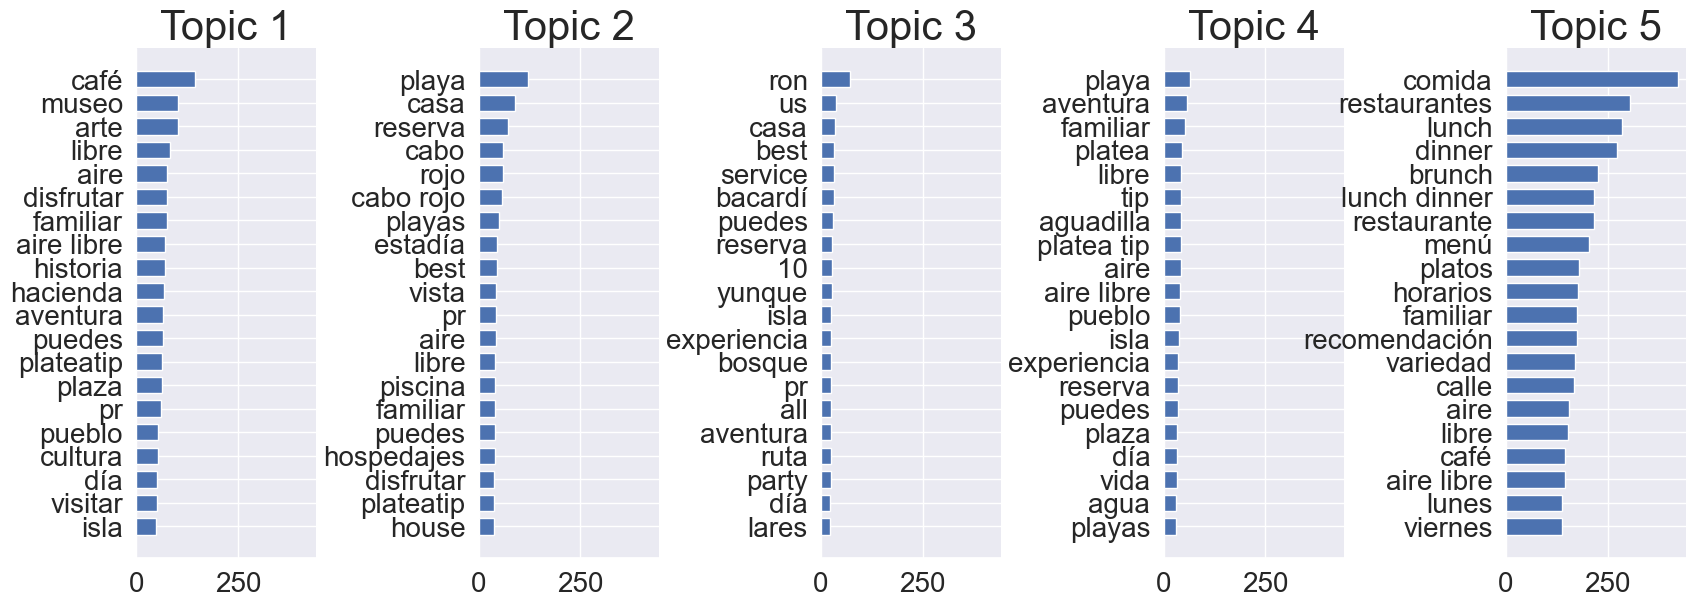

In [647]:
tf_feature_names = tf_vectorizer.get_feature_names_out()
plot_top_words(lda, tf_feature_names, n_top_words, "")

In [648]:
len(tf_feature_names)

10000

### We can also visualize the topic distribution of a particular article - because of how the LDA model works

The code below will take a random sample article and visualize the topic distribution of that text

In [649]:
#get topic "names" - by taking the 4 most likely word tokens in the topic
topic_names = get_topic_names(lda, feature_names=tf_feature_names, n_top_words=4)

In [650]:
sample_idx = np.random.choice(len(texts))
sample_idx

8

In [651]:
print(texts[sample_idx])

El gobierno anunció la exención temporeramente del pago del Impuesto sobre Ventas y Uso IVU, a los alimentos preparados a partir del próximo jueves, 22 de septiembre de 2022, tras el paso del huracán Fiona por Puerto Rico. Además de alimentos preparados, la exención incluye bebidas carbonatadas, productos de repostería y dulces, según definidos en la Sección 4010.01 del Código de Rentas Internas de Puerto Rico de 2011, según enmendado. No será aplicable a la venta de bebidas alcohólicas. PlateaPick: Restaurantes y coffee shops locales abiertos tras el paso de Fiona por la isla Esta es una de las acciones afirmativas que estamos tomando como gobierno para darle un alivio a los ciudadanos, mientras continuamos con la respuesta a la emergencia, manifestó el gobernador, Pedro Pierluisi en la solicitud que concedió el Departamento de Hacienda. La exención estará vigente hasta el próximo 6 de octubre de 2022. Se informó que, en caso de que un comerciante cobre al consumidor el IVU, el client

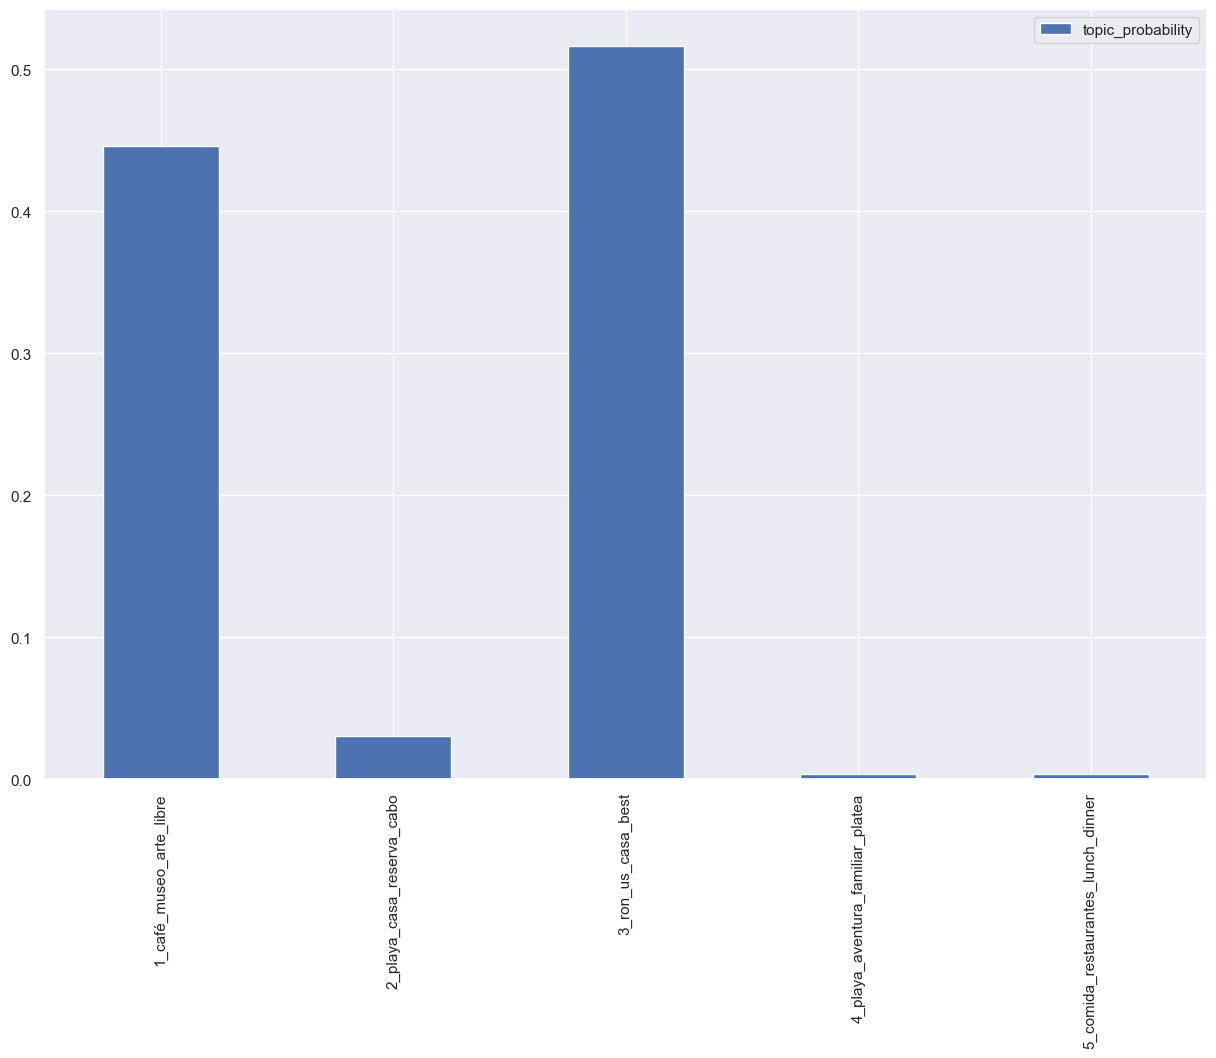

In [652]:
pd.DataFrame(index= topic_names, data= clusters[sample_idx], columns = ["topic_probability"]).plot.bar(figsize = (15,10), rot=90)
plt.show()

In [653]:
titles = data.title
topics = []
for i in range(len(data)):
    probs = pd.DataFrame(index= topic_names, data= clusters[i], columns = ["topic_probability"])
    # print(titles[i], ": ",probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0])
    topics.append(probs[probs.topic_probability ==  max(probs.topic_probability)].index.values[0]) 


In [654]:
data['topic']=topics  
data.head()


,title,content,link,date,author,type,topic
0,9 eventos de Halloween que no te puedes perder...,Por si andas buscando a qué fiesta llegar ante...,https://www.plateapr.com/eventos-de-halloween-...,2022-10-14T07:05:00,13,post,2_playa_casa_reserva_cabo
1,8 terrazas únicas donde puedes tomarte un buen...,En Puerto Rico no faltan los coffee shops. Ya ...,https://www.plateapr.com/terrazas-unicas-donde...,2022-10-13T13:18:57,13,post,5_comida_restaurantes_lunch_dinner
2,Todo lo que puedes hacer en Caguas con solo $30,En el amplio valle de Caguas puedes toparte co...,https://www.plateapr.com/que-hacer-en-caguas-p...,2022-10-11T14:20:40,13,post,4_playa_aventura_familiar_platea
3,"Jazz, laberintos embrujados y otras 8 activida...","Llegó el mes de las brujas y con él, todas las...",https://www.plateapr.com/que-hacer-este-fin-de...,2022-10-07T02:24:00,13,post,2_playa_casa_reserva_cabo
4,3 restaurantes que dan cátedra de recuperación...,A la hora de ser solidarios en la recuperación...,https://www.plateapr.com/restaurantes-recupera...,2022-10-05T17:27:05,34,post,5_comida_restaurantes_lunch_dinner


In [655]:
# Counting number of posts by topic
counts = data['topic'].value_counts().reset_index()
counts = counts.rename(columns={"topic": "count", "index":"topic"})
counts

,topic,count
0,5_comida_restaurantes_lunch_dinner,75
1,1_café_museo_arte_libre,34
2,2_playa_casa_reserva_cabo,30
3,3_ron_us_casa_best,25
4,4_playa_aventura_familiar_platea,20


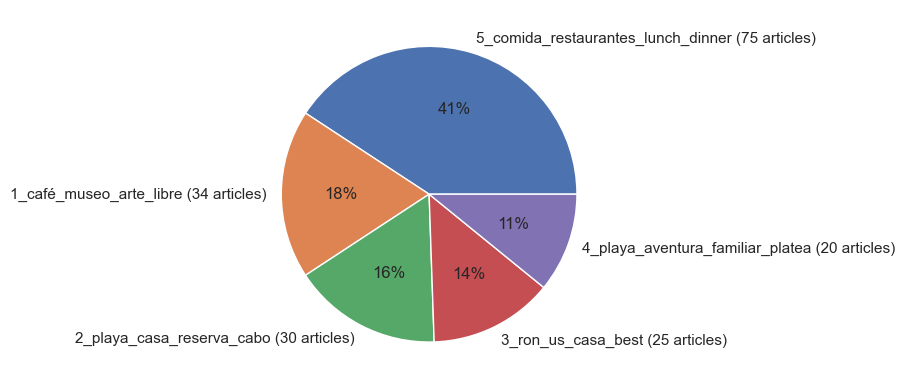

In [656]:

labels = []

for value, topic in zip(counts['count'].values, counts.topic.values):
    labels.append(f'{topic} ({value} articles)')


plt.pie(counts['count'].values, labels = labels, autopct='%.0f%%')
plt.show()

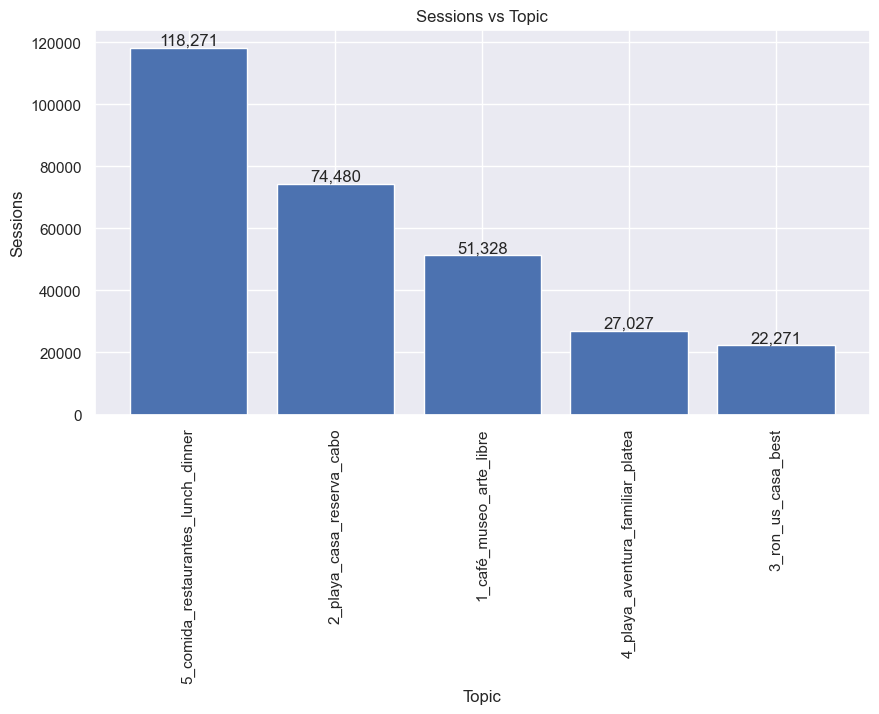

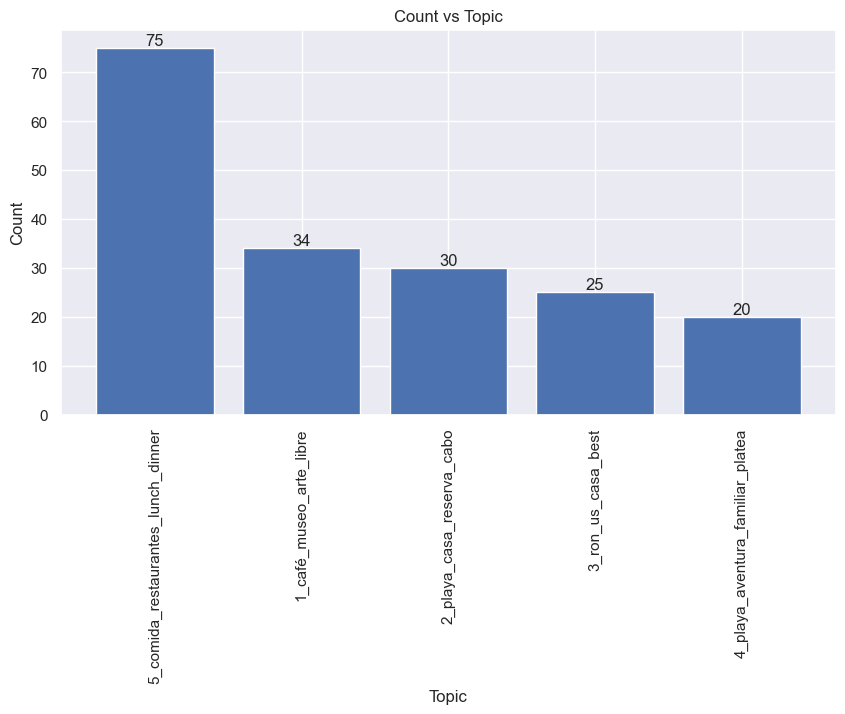

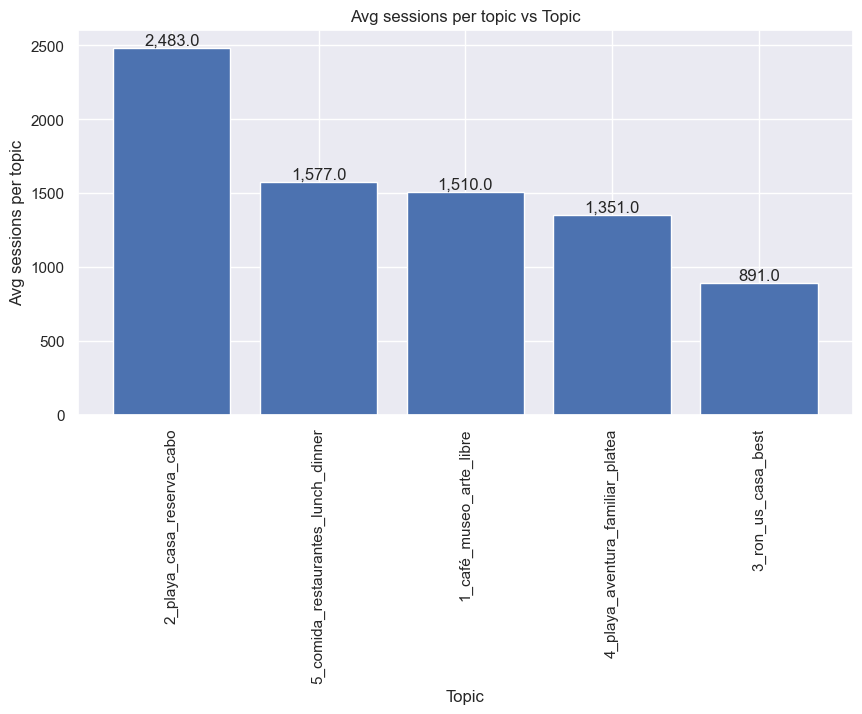

In [657]:
# Counting number of posts by topic
counts = data['topic'].value_counts().reset_index()
counts = counts.rename(columns={"topic": "count", "index":"topic"})


combined = pd.merge(data,  pd.read_csv("./data/sessions_sum.csv"), how='inner', left_on = 'link', right_on = 'url_clean')
by_topic = combined.groupby('topic').agg({'sessions': 'sum'}).reset_index()
by_topic = pd.merge(by_topic, counts, how='inner', left_on = 'topic', right_on = 'topic')

by_topic['AVG sessions per topic'] = round(by_topic['sessions']/by_topic['count'],0)


y_values = [c for c in by_topic.columns if c != 'topic']
for c in y_values:
    sorted_df = by_topic.sort_values(by=[c], ascending=False)
    figure = plt.figure('myfigureid', figsize = (10,5))
    axis = figure.add_subplot(1,1,1)
    axis.bar(sorted_df['topic'], sorted_df[c])
    
    rects = axis.patches

    # Make some labels.

    for rect, label in zip(rects, sorted_df[c]):
        height = rect.get_height()
        axis.text(
            rect.get_x() + rect.get_width() / 2, height, "{:,}".format(label), ha="center", va="bottom"
        )

    axis.set_ylabel(c.capitalize())
    axis.set_xlabel('topic'.capitalize())
    axis.set_title(f"{c.capitalize()} vs Topic")
    plt.xticks(rotation = 90)
    plt.show()

In [633]:
# See the titles on each topic to get an idea

for topic in counts['topic'].values:
    print(topic)
    for title in combined[combined.topic ==topic]['title'].values:
        print(f'\t\t{title}')
    print('\n')

5_comida_restaurantes_lunch_dinner
		8 terrazas únicas donde puedes tomarte un buen café
		3 restaurantes que dan cátedra de recuperación tras Fiona
		Restaurantes y coffee shops locales abiertos tras el paso de Fiona por la isla
		Coffee shops para coffee lovers en San Juan
		Librerías locales con café para refugiarte durante los días lluviosos
		8 lugares con buenos especiales de almuerzo por $12 o menos
		Ocho barras con vista al mar para visitar en Puerto Rico
		Kioskos en Piñones para matar los munchies después de la playa
		¡Día del Perro en Puerto Rico! Los 6 jangueos para celebrar con tu mascota
		Spots en el oeste para ver la puesta del sol
		6 spots con cervezas bien frías para ver el juego
		7 pizzerías cerca de San Juan para los foodies más exigentes
		Nuevos restaurantes en la zona metro que hay que probar sí o sí en agosto
		Restaurantes románticos para tu date night en San Juan
		Qué hacer y comer con $30 en la Calle Loíza
		7 barras para visitar después de un día largo 

In [661]:
combined.groupby('link').agg({'sessions': 'sum', 'views':'sum', 'return_visitors':'sum'}).reset_index().sort_values(by=['sessions'], ascending=False)[0:30].groupby('link').agg({'sessions': 'sum', 'views':'sum', 'return_visitors':'sum'}).reset_index().sort_values(by=['sessions'], ascending=False)[0:30]

,link,sessions,views,return_visitors
20,https://www.plateapr.com/que-hacer-este-fin-de...,35055,87706,10516
21,https://www.plateapr.com/restaurantes-con-vist...,8899,14987,2276
25,https://www.plateapr.com/restaurantes-hidden-g...,6328,16617,1657
29,https://www.plateapr.com/ver-el-live-del-conci...,4620,10279,743
11,https://www.plateapr.com/lugares-para-celebrar...,4619,6847,705
1,https://www.plateapr.com/alquileres-vacacional...,4582,6481,851
8,https://www.plateapr.com/librerias-locales-en-...,4302,7998,948
28,https://www.plateapr.com/spots-para-ver-el-ata...,4282,7055,1348
18,https://www.plateapr.com/playas-escondidas-en-...,4245,10478,1255
23,https://www.plateapr.com/restaurantes-en-caguas/,4186,6389,1237
